In [1]:
!git clone https://github.com/shaotao-art/Unsupervised-Classification-SCAN
%cd /content/Unsupervised-Classification-SCAN
!pwd

Cloning into 'Unsupervised-Classification-SCAN'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 59 (delta 6), reused 59 (delta 6), pack-reused 0
Unpacking objects: 100% (59/59), done.
/content/Unsupervised-Classification-SCAN
/content/Unsupervised-Classification-SCAN


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import os
from torch import nn
from sklearn.cluster import KMeans

from src_py.transforms import ValT
from src_py.models import get_model

## Results
we will explore things as follows:
1. after training pretext task, we will find nearest neighbot in features space and find whether they are close in RGB space
2. test the accuracy of kmeans after pretext
3. test the accuracy after scan step
3. test the accuracy after self label step


In [14]:
import pathlib
from google_drive_downloader import GoogleDriveDownloader as gdd

ckp_path = './ckp'
extracted_file_path = './extracted_files'

pathlib.Path(ckp_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(extracted_file_path).mkdir(parents=True, exist_ok=True)

%cd ./ckp
!gdown 1-Ib1HJv9tmk0ckqRMwQdGMdFTPjV_9EW
!gdown 1-CAwZ7FGH8CH6es0ie0l_07U8N9pXjgI
!gdown 1-QKepjxMBSFvcRwt48SU6PAorKmHhjBo
%cd ../extracted_files
!gdown 1-BpvipyaR319FW6jMbdfuk8e5une_FZl
!gdown 1-9J9slpogUJP6JmH5r1mZTjT_ASAIKtS
!gdown 1HqClDvuVZwNTYWO9ulOvB9ynpZ0A9-5z
!gdown 1tUaG6008bbrjA-TyoI0zqnXqY5kFRQ0j
%cd ..

/content/Unsupervised-Classification-SCAN/ckp
Downloading...
From: https://drive.google.com/uc?id=1-Ib1HJv9tmk0ckqRMwQdGMdFTPjV_9EW
To: /content/Unsupervised-Classification-SCAN/ckp/pretext.ckp
100% 92.1M/92.1M [00:00<00:00, 241MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CAwZ7FGH8CH6es0ie0l_07U8N9pXjgI
To: /content/Unsupervised-Classification-SCAN/ckp/scan_10.ckp
100% 134M/134M [00:00<00:00, 300MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-QKepjxMBSFvcRwt48SU6PAorKmHhjBo
To: /content/Unsupervised-Classification-SCAN/ckp/selflabel_10.ckp
100% 134M/134M [00:00<00:00, 274MB/s]
/content/Unsupervised-Classification-SCAN/extracted_files
Downloading...
From: https://drive.google.com/uc?id=1-BpvipyaR319FW6jMbdfuk8e5une_FZl
To: /content/Unsupervised-Classification-SCAN/extracted_files/train_knn_indices.npy
100% 8.40M/8.40M [00:00<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-9J9slpogUJP6JmH5r1mZTjT_ASAIKtS
To: /content/Unsupervised-Classific

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 32
b_s = 32

num_class = 10
num_head = 1

plt.tight_layout()
# plt.rcParams['figure.dpi'] = 300 #分辨率
# plt.figure().set_size_inches(100, 100)

<Figure size 432x288 with 0 Axes>

In [5]:
class BaseData(Dataset):
    """
    dataset to load image
    """
    def __init__(self, transform=None, train=True, download=True):
        super(BaseData, self).__init__()
        self.datas = torchvision.datasets.CIFAR10(root='./data', train=train, download=download)
        self.T = transform

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, index):
        # only return images
        # do not return labels
        if self.T is None:
            return self.datas[index][0], self.datas[index][1]
        else:
            return self.T(self.datas[index][0]), self.datas[index][1]

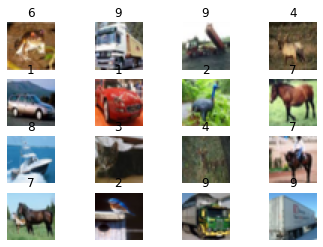

In [6]:
# plot sample image in dataset
train_data =  BaseData(None, train=True)
test_data = BaseData(None, train=False)
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_data[i][0])
    plt.title(train_data[i][1])
    plt.axis("off")

# Pretext

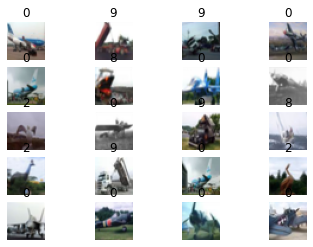

In [7]:
knn_indices = np.load('./extracted_files/train_knn_indices.npy')
# plot an image and its nearest label in feature space
sample_id = 2
for i in range(20):
    plt.subplot(5, 4, i+1)
    sample = train_data[knn_indices[sample_id][i+1]]
    plt.imshow(sample[0])
    plt.title(sample[1])
    plt.axis("off")

## Make Dataset

In [8]:
train_data =  BaseData(transform=ValT(img_size), train=True)
test_data = BaseData(transform=ValT(img_size), train=False)
print('len train data: ', len(train_data), ', len test data:', len(test_data))
train_loader = DataLoader(train_data, batch_size=b_s, shuffle=False)
test_loader = DataLoader(test_data, batch_size=b_s, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
len train data:  50000 , len test data: 10000


In [9]:
def get_pred(dataloader, model, device, num_crop):
    pred_lst = []
    softmax = nn.Softmax(dim=1)
    model = model.to(device)
    with torch.no_grad():
      for x, y in tqdm(dataloader):
        feature = [softmax(model(x.to(device))[0]).unsqueeze(1) for _ in range(num_crop)]
        features = torch.cat(feature, dim=1)
        features = features.mean(dim=1)
        pred_lst.append(features)
        # y_lst.append(y)
    return torch.cat(pred_lst).cpu()


def get_labels(dataloader):
    y_lst = []
    for _, y in tqdm(dataloader):
        y_lst += [int(_) for _ in list(y)]
    return y_lst


# Kmeans

In [12]:
features = np.load('./extracted_files/train_features.npy')
kmeans = KMeans(n_clusters=10, random_state=2022).fit(features)
idxs = kmeans.labels_
labels = get_labels(train_loader)
sum_right = 0
for i in range(10):
    # i use the actual label in oder to get the best acc
    filt1 = idxs == i
    s = np.array(labels)[filt1]
    num_right = Counter(s).most_common(1)[0][1]
    sum_right += num_right
print(f'acc in train set: {sum_right / len(train_data)}')

100%|██████████| 1563/1563 [00:13<00:00, 115.23it/s]


acc in train set: 0.3403


In [15]:
features = np.load('./extracted_files/test_features.npy')
idxs = kmeans.predict(features)
labels = get_labels(test_loader)
sum_right = 0
for i in range(10):
    # i use the actual label in oder to get the best acc
    filt1 = idxs == i
    s = np.array(labels)[filt1]
    num_right = Counter(s).most_common(1)[0][1]
    sum_right += num_right
print(f'acc in train set: {sum_right / len(test_data)}')

100%|██████████| 313/313 [00:03<00:00, 83.83it/s]

acc in train set: 0.3466


# Scan Acc

In [16]:
scan_model_path = os.path.join(ckp_path, 'scan_10.ckp')
checkpoint = torch.load(scan_model_path, map_location='cpu')
model_config = {'mode':'scan', 'num_class':num_class, 'num_head':num_head}
model = get_model(model_config)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [17]:
num_crop = 1
pred = get_pred(train_loader, model, device, num_crop)
labels = get_labels(train_loader)
sum_right = 0
v, idxs = torch.max(pred, dim=1)
for i in range(10):
    # i use the actual label in oder to get the best acc
    filt1 = idxs == i
    s = np.array(labels)[filt1]
    num_right = Counter(s).most_common(1)[0][1]
    sum_right += num_right
print(f'acc in train set: {sum_right / len(train_data)}')


100%|██████████| 1563/1563 [00:13<00:00, 115.74it/s]


acc in train set: 0.75834


In [18]:
num_crop = 1
pred = get_pred(test_loader, model, device, num_crop)
labels = get_labels(test_loader)
sum_right = 0
v, idxs = torch.max(pred, dim=1)
for i in range(10):
    # i use the actual label in oder to get the best acc
    filt1 = idxs == i
    s = np.array(labels)[filt1]
    num_right = Counter(s).most_common(1)[0][1]
    sum_right += num_right
print(f'acc in test set: {sum_right / len(test_data)}')

100%|██████████| 313/313 [00:02<00:00, 122.40it/s]

acc in test set: 0.7562


# Selflabel Acc

In [19]:
self_label_model_path = os.path.join(ckp_path, 'selflabel_10.ckp')
checkpoint = torch.load(self_label_model_path, map_location='cpu')
model_config = {'mode':'scan', 'num_class':num_class, 'num_head':num_head}
model = get_model(model_config)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [20]:
num_crop = 1
pred = get_pred(train_loader, model, device, num_crop)
labels = get_labels(train_loader)
sum_right = 0
v, idxs = torch.max(pred, dim=1)
for i in range(10):
    filt1 = idxs == i
    s = np.array(labels)[filt1]
    num_right = Counter(s).most_common(1)[0][1]
    sum_right += num_right
print(f'acc in train set: {sum_right / len(train_data)}')


100%|██████████| 1563/1563 [00:13<00:00, 119.79it/s]


acc in train set: 0.85626


In [21]:
num_crop = 1
pred = get_pred(test_loader, model, device, num_crop)
labels = get_labels(test_loader)
sum_right = 0
v, idxs = torch.max(pred, dim=1)
for i in range(10):
    filt1 = idxs == i
    s = np.array(labels)[filt1]
    num_right = Counter(s).most_common(1)[0][1]
    sum_right += num_right
print(f'acc in test set: {sum_right / len(test_data)}')

100%|██████████| 313/313 [00:02<00:00, 118.94it/s]

acc in test set: 0.841
